In [3]:
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset , DataLoader
import matplotlib.pyplot as plt
import os


def binary_mask(img_path : str)-> np.ndarray:

    try:
        img = Image.open(img_path).convert('RGB')
        img_arry = np.array(img)
    except FileNotFoundError:
        print("Error Not found")
        return None

    
    height ,width,_ = img_arry.shape

    mask = np.zeros((height,width), dtype = np.int64)

    purple_color = np.array([138,43,226])

    belgium_pixels = np.all(img_arry == purple_color , axis=-1)

    mask[belgium_pixels] = 1

    return mask

class BorderDataset(Dataset):

    def __init__(self , image_path : str):
        
        self.mask = binary_mask(img_path=image_path)
        if self.mask is None:
            raise RuntimeError("mask Not created")
        
        self.height , self.width  = self.mask.shape

        self.pixel_data = []
        for y in range (self.height):
            for x in range(self.width):
                label = self.mask[y,x]
                self.pixel_data.append(((x,y), label))


    def __len__(self) -> int:

        return self.width * self.height
    

    def __getitem__(self , idx : int) -> tuple[torch.Tensor , torch.Tensor]:

        (x_cord , y_cord) , label = self.pixel_data[idx]

        x_norm = x_cord / (self.width-1)
        y_norm = y_cord / (self.height - 1)

        coordinates = torch.tensor([x_norm , y_norm] , dtype= torch.float32)

        label = torch.tensor(label , dtype=torch.long)

        return coordinates , label
    

class Linear:

    def __init__(self , input_width : int  , output_width : int , activation_function):

        self.input_width = input_width
        self.output_width  = output_width
        self.activation = activation_function

        self.W = np.random.randn(self.output_width , self.input_width) * 0.01
        self.b = np.zeros((self.output_width,1))

        self.dw = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

        self.A_prev = None
        self.Z = None


    def forward(self , A_prev : np.ndarray) -> np.ndarray:

        self.A_prev = A_prev
        self.Z = np.dot(self.W , self.A_prev) + self.b
        A = self.activation.forward(self.Z)
        return A
    
    def backward(self , dA : np.ndarray) -> np.ndarray:

        m = self.A_prev.shape[1]

        dZ = dA * self.activation.backward(self.Z)

        self.dw = (1/m) * np.dot(dZ , self.A_prev.T)
        self.db = (1/m) * np.sum(dZ , axis = 1 ,keepdims=True)

        dA_prev = np.dot(self.W.T , dZ)
        return dA_prev



class ReLU:

    def forward(self ,Z: np.ndarray) -> np.ndarray:

        return np.maximum(0,Z)
    
    def backward(self, Z: np.ndarray) -> np.ndarray:

        derivative = (Z > 0).astype(float)
        return derivative
    

class Tanh:

    def forward(self ,Z: np.ndarray) -> np.ndarray:

        return np.tanh(Z)
    
    def backward(self, Z: np.ndarray) -> np.ndarray:

        return 1-np.tanh(Z)**2
    

class Sigmoid:

    def forward(self ,Z: np.ndarray) -> np.ndarray:

       Z_clipped = np.clip(Z ,-500 , 500)
       return 1/(1 + np.exp(-Z_clipped))

    
    def backward(self, Z: np.ndarray) -> np.ndarray:

        s = self.forward(Z)
        return s * (1-s)
    


class Identity:

    def forward(self ,Z: np.ndarray) -> np.ndarray:

        return Z
    
    def backward(self, Z: np.ndarray) -> np.ndarray:

        return np.ones_like(Z)
    

class Model:

    def __init__(self , layers : list , loss_function_type : str = "MSE" , learning_rate : float = 0.01):

        self.layers = layers
        self.learning_rate = learning_rate

        if loss_function_type.upper() == "MSE":
            self.loss_func = self.mean_squared_error
            self.loss_derivative = self.mean_squared_error_derivative
        elif loss_function_type.upper() == "BCE":
            self.loss_func = self.binary_cross_entropy
            self.loss_derivative = self.binary_cross_entropy_derivative
        else:
            raise ValueError("Unsupported loss function")
        

    def mean_squared_error(self , y_pred , y_train):
        return np.mean((y_pred - y_train) ** 2)
    
    def mean_squared_error_derivative(self, y_pred , y_true):
        return 2* (y_pred - y_true) / y_true.size
    
    def binary_cross_entropy(self , y_pred , y_true):

        epsilon = 1e-15
        y_pred = np.clip(y_pred , epsilon , 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1- y_true) * np.log(1- y_pred) )
    
    def binary_cross_entropy_derivative(self , y_pred , y_true):

        epsilon = 1e-15
        y_pred = np.clip(y_pred , epsilon , 1-epsilon)
        return -(y_true / y_pred - (1 - y_true) / (1 - y_pred))
    

    def forward(self , X : np.ndarray) -> np.ndarray:

        A = X
        for layer in self.layers:
            A = layer.forward(A)
        return A
    
    def backward(self , dAL : np.ndarray):

        dA = dAL
        for layer in reversed(self.layers):
            dA = layer.backward(dA)


    def train(self , x : np.ndarray , y : np.ndarray) -> float:

        y_pred = self.forward(x)
        loss = self.loss_func(y_pred , y)
        dAL = self.loss_derivative(y_pred , y)
        self.backward(dAL)
        return loss
    



    


         


# Ques 1 Belgium Netherlands Border

### 1.1 Image Processing and Dataset Creation 

#### Binary Mask

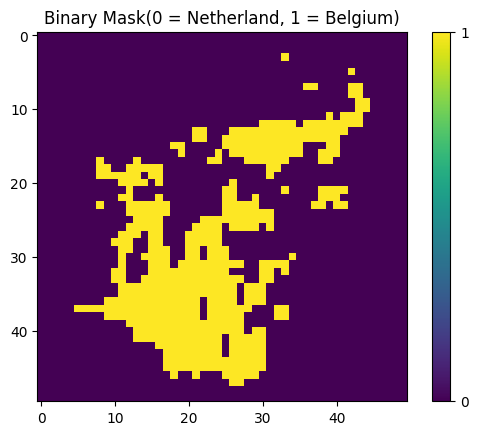

In [4]:
Imagepath = "border.png"

Binary_mask = binary_mask(img_path= Imagepath)

plt.imshow(Binary_mask , cmap="viridis")
plt.title(('Binary Mask(0 = Netherland, 1 = Belgium)'))
plt.colorbar(ticks = [0,1])
plt.show()

#### Border Dataset

In [28]:
Imagepath = "border.png"

border_dataset = BorderDataset(image_path= Imagepath)
data_loder = DataLoader(border_dataset , batch_size=10 ,shuffle=True )

print(f" Total Samples : {len(border_dataset)}")

cords_batch , labels_batch = next(iter(data_loder))
print(f"Coordinates Tensor Shape:{cords_batch.shape}")
print(f"labels Tensor Shape: {labels_batch.shape}")
print(f"Sample Coordinates(Normalized):\n" , cords_batch)
print(f"Corresponding Labels: \n" , labels_batch)
            


 Total Samples : 2500
Coordinates Tensor Shape:torch.Size([10, 2])
labels Tensor Shape: torch.Size([10])
Sample Coordinates(Normalized):
 tensor([[0.2245, 0.3469],
        [0.2041, 0.8776],
        [0.7755, 0.4082],
        [0.2245, 0.9184],
        [0.5714, 0.8163],
        [0.2449, 0.7755],
        [0.1020, 0.0204],
        [0.2857, 0.3469],
        [0.9388, 0.7755],
        [0.5918, 0.1224]])
Corresponding Labels: 
 tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
